In [1]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras
"""

# generic imports
import sys
import os
import numpy as np
import geopandas as gpd
import time
import geemap
import geojson
import ee
import rioxarray as rxr
import matplotlib.pyplot as plt
ee.Initialize()

# specific imports
from typing import Any, Dict, List, Optional
from geojson import Feature, FeatureCollection, dump
from shapely.geometry import Polygon, MultiPolygon, shape
from dateutil.relativedelta import *
from google.cloud import storage
from logging import Logger, getLogger
from googleapiclient.discovery import build
from re import sub
from ctypes import ArgumentError
from functools import partial
from dateutil.parser import parse

# custom functionality import without requirement to pip install package
local_path = r"C:\Users\kras\Documents\GitHub\ee-packages-py"  # path to local GitHub clone
sys.path.append(local_path)
from eepackages.applications.bathymetry import Bathymetry
from eepackages import tiler

logger: Logger = getLogger(__name__)

C:\Users\kras\AppData\Local\Temp\ipykernel_8608\1041980866.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# see scheme at https://github.com/openearth/eo-bathymetry/blob/master/notebooks/rws-bathymetry/acces_api.pdf for a workflow visualization 

# project toggles
main_fol = r"p:\11209821-cmems-global-sdb" # name of the main local folder 
bucket = "cmems-sdb" # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r"p:\11209821-cmems-global-sdb\00_miscellaneous\KEYS\bathymetry-543b622ddce7.json" # Cloud Storage credential key
output_fol = r"01_intertidal\02_data\05_calibrated" # name of the overall project
project_name = "AOI_GER_WaddenSea" # name of the project AoI
draw_AoI = 0 # toggle 1 to draw AoI, 0 to load

# composite image toggles
mode = "intertidal" # specify mode, either "intertidal" or "subtidal"
start_date = "2021-01-01" # start date of the composites
stop_date = "2022-01-01" # end date of the composites
compo_int = 12 # composite interval [months]
compo_len = 12 # composite length [months]
scale = 100  # output resolution of the image from download proxies [m]
upscale = 100 # upscaled resolution for the image [m]
crs = "EPSG:4326" # output projection of the image

# tiling options
zoomed_list = [9, 10, 11] # list with zoom levels to be inspected
sel_tile = 2 # idx of chosen tile level in zoomed_list (inspect the map to chose it accordingly), z9 too big for in memory computations
# note, see https://www.openearth.nl/rws-bathymetry/2019.html; Z9 is optimal size..

# load google credentials, if specified
if not credential_file == "":  
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credential_file)

# Validation data

In [7]:
# TODO: convert LAT to MSL for validation data here (Martin)
# See p:\11209821-cmems-global-sdb\04_validation\01_example_scripts\test_gebco_zarr_with_xarray.ipynb

valfiles = os.listdir(os.path.join(main_fol, "00_miscellaneous\Validation_data"))
for i in valfiles:
    if project_name[4:] in i:
        val_data = rxr.open_rasterio(os.path.join(main_fol, "00_miscellaneous\Validation_data", i))

In [14]:
val_data_masked = val_data.where(val_data.values != val_data.attrs["_FillValue"])  

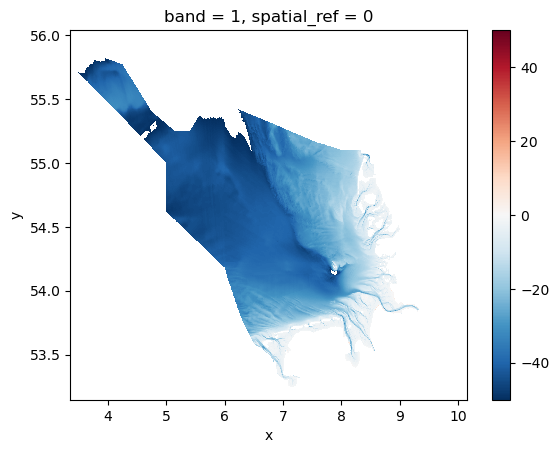

In [16]:
val_data_masked.plot()